### Machine Learning Techniques for Distinguishing Between Human and AI-Generated Text
**(Part 1 - Modeling)**

** by Mykhaylo Chuba **


**Rationale:**
In the era of information proliferation, distinguishing between human and AI-generated content is vital to address issues of authenticity, misinformation, and trust. Understanding the characteristics of AI-generated text can help make AI tools more transparent and accountable. With the increasing use of AI in generating content, it becomes crucial to ensure compliance with copyright laws, academic requirements, and regulations. By identifying AI-generated texts accurately, we can prevent the misuse of AI and contribute to safer AI deployments.

**Research Question:**
Can machine learning models effectively differentiate between text generated by humans and text produced by artificial intelligence?

**Methodology:**
For this natural language processing experiment, I’m using a variety of machine learning classification techniques, such as Logistic Regression, Decision trees, KNN and SVM. The analysis involves preprocessing the text, extracting features that could distinguish between human and AI texts, and selecting the best-performing model based on evaluation techniques such as accuracy score, precision, recall, F1-score, time-to-fit, etc.

**Results:**
During the project, I evaluated four different natural language processing models, including Logistic Regression, Decision Trees, KNN and SVM. SVM had the highest accuracy score of 0.986 with the best parameters {'svc__C': 10, 'svc__kernel': 'rbf', 'vect__max_features': 5000}; however, it took the longest time to fit of 316 sec. Therefore, I recommend using the Logistic Regression model, which had a slightly lower accuracy score of 0.983 with best parameters {'lgr__C': 0.1, 'vect__max_features': 5000}, but it took only 1 sec to fit. For 0.3% reduction in accuracy compared to SVM, it consumes 316X less computational power. This could be particularly beneficial if we want to scale the model and fit it on a larger data set. It also produces the highest recall score of 0.986. Since maximizing for the True Positives is arguably more important in classifying human vs. AI-generated text, as it reduces the amount of misclassified human as AI, Logistic Logistic is definitely better suited for this task.

**Data Sources:**
https://www.kaggle.com/datasets/shanegerami/ai-vs-human-text/data




####

#### Import Libraries


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import nltk
import string
import re
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import word_tokenize
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_score, mean_squared_error, accuracy_score, recall_score,f1_score

####


#### Data Upload and Setup

In [2]:
# Load data set
data = pd.read_csv('AI_Human.csv')

In [3]:
# Show data frame and shape
print(data.shape)
data.head()

(487235, 2)


,text,generated
0,Cars. Cars have been around since they became ...,0.0
1,Transportation is a large necessity in most co...,0.0
2,"""America's love affair with it's vehicles seem...",0.0
3,How often do you ride in a car? Do you drive a...,0.0
4,Cars are a wonderful thing. They are perhaps o...,0.0


In [4]:
# print value counts
print(data['generated'].value_counts())

generated
0.0    305797
1.0    181438
Name: count, dtype: int64


In [5]:
# Convert int64 data type to int
data['generated'] = data['generated'].astype(int)

In [6]:
# Reduce the size of the dataset to 20,000 rows and establish the class balance as 50/50   

# Filter the DataFrame by class
ai_generated = data[data['generated'] == 1]
not_ai_generated = data[data['generated'] == 0]

# Sample 25000 rows from each class
ai_sample = ai_generated.sample(n=10000, random_state=123) 
not_ai_sample = not_ai_generated.sample(n=10000, random_state=123)

# Combine and shuffle the samples
data1 = pd.concat([ai_sample, not_ai_sample]).sample(frac=1, random_state=123)

In [7]:
# Rename columns
data1.columns = ['text', 'ai_generated']

# Reset the index
data1.reset_index(drop=True, inplace=True)

####


#### Data Analysis and Visualization

In [8]:
data1.head()

,text,ai_generated
0,"Dear Principle,\n\nI think that the principle ...",0
1,"Dear TEACHER_NAME,\n\nIn consideration of the ...",0
2,When people ask for advice they sometimes talk...,0
3,I agree that advertisements often make product...,1
4,Education is a life-long process. I agree with...,1


In [9]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text          20000 non-null  object
 1   ai_generated  20000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 312.6+ KB


Text(0.5, 1.0, 'AI vs Human Text Class Distribution')

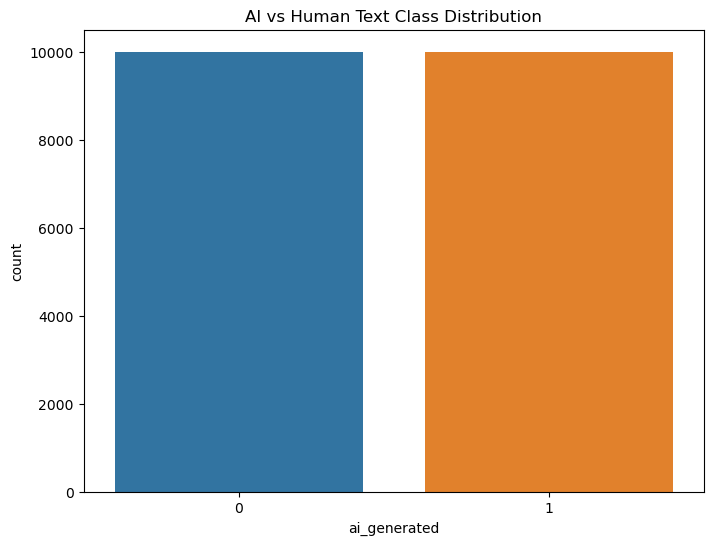

In [53]:
# Visualize and confirm class distribution

plt.figure(figsize=(8, 6))
ax = sns.countplot(x='ai_generated', data=data1)
ax.set_title("AI vs Human Text Class Distribution")

In [11]:
# Create text length summary
data1['count'] = data1.text.apply(len)
print('Min character count:', data1['count'].min())
print('Max character count:', data1['count'].max())
print('Average character count:', data1['count'].mean())

Mean character count: 2236.20985
Min character count: 229
Max character count: 9175


In [12]:
# Show an example of non-AI generated text
print('non-AI text:', data1['ai_generated'].iloc[0])
data1['text'].iloc[0]

non-AI text: 0


"Dear Principle,\n\nI think that the principle is being unfair because students are actually trying there best on having good grades. I think he should give them one more chance because there trying there best. If you don't do anything about them, we would were going to sign a petition and were going to get the whole students get it sigh even the teachers. If you still don't let them play a sport then were going to get our super attended on this and I know he would do something about it because he's nice. He's going to see that were trying our best on our grades.\n\nSo either you want to do it the nice wag or you want to do it the bad wag? Its four choice were just letting you know before we go and do it the bad wag. It's not fair that you taking our sports away from us that's the only good thing we have in school and friends so please I'm asking nicely don't take our sports away from us.\n\nWe promise were going to try our best on getting a better grade then before. We promise were go

In [13]:
# Show an example of AI generated text
print('AI text:', data1['ai_generated'].iloc[3])
data1['text'].iloc[3]

AI text: 1


"I agree that advertisements often make products seem better than they really are. Advertisers use a variety of techniques to make products seem more appealing than they really are.\n\nFirst, advertisers often use attractive models or celebrities to sell products. They are usually shown using or enjoying the product in a positive way. This creates the impression that if we buy the product, we will also be attractive and happy like the people in the advertisement.\n\nSecond, advertisers often use unrealistic images or situations to sell products. For example, they may show a person using a product in a way that is not possible in real life. Or they may show a product as being much better than it really is. This can make us believe that the product is better than it really is.\n\nThird, advertisers often make false claims about products. They may say that a product can do something that it really can't. Or they may claim that a product is much better than it really is. This can make us b

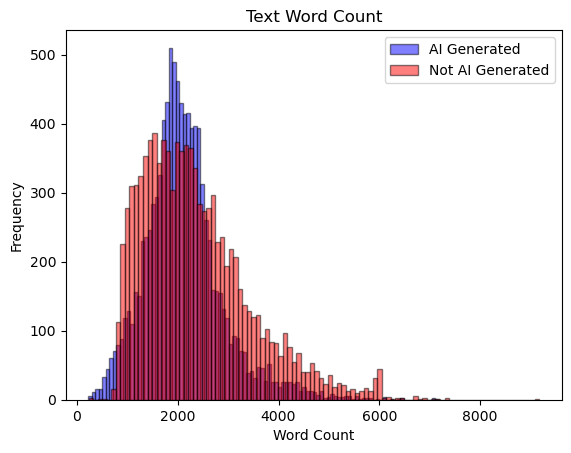

In [54]:
# Create Word Count graph

# Filter data based on 'ai_generated' category
ai_generated_data = data1[data1['ai_generated'] == 1]
not_ai_generated_data = data1[data1['ai_generated'] == 0]

# Create the histogram using matplotlib
fig, ax = plt.subplots()
ax.hist(ai_generated_data['count'], bins=100, color='blue', alpha=0.5, edgecolor='black', label='AI Generated')
ax.hist(not_ai_generated_data['count'], bins=100, color='red', alpha=0.5, edgecolor='black', label='Not AI Generated')

ax.set_title('Text Word Count')
ax.set_xlabel('Word Count')
ax.set_ylabel('Frequency')
ax.legend()

plt.show()

####


#### Data Processing

In [15]:
# Split data into train and test
X = data1['text']
y = data1['ai_generated']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [16]:
# Example of preprocessed text
X_train.iloc[0]

']\n\nDear Senator [Senator’s Last Name],\n\nI am writing to express my position on the issue of the Electoral College and to urge you to consider the reasons for both keeping it and transitioning to a popular vote system for the election of the President of the United States. As a concerned citizen, I believe that it is important to explore the advantages and disadvantages of each system in order to make an informed decision.\n\nThe Electoral College, as defined of the Office of the Federal Register, was established as a compromise between the election of the President of a vote in Congress and of a popular vote of qualified citizens. It consists of 538 electors, and a majority of 270 electoral votes is required to elect the President. The electors are chosen of the candidate\'s political party, and most states have a "winnertakeall" system, awarding all electors to the winning presidential candidate.\n\nProponents of the Electoral College, such as Judge Richard A. Poster, argue that 

In [17]:
# Set up a function for tokenization, removing stop words, punctuation, numbers; set lower case, and lemmatize
def preprocess_text(text):
    tokenizer = TweetTokenizer(preserve_case = False)
    swords = stopwords.words('english')
    punc = list(string.punctuation)
    lemmatizer = WordNetLemmatizer()
    
    processed_text = []
    for entry in text:
        entry = re.sub(r'\d+', '', entry)
        tokens = tokenizer.tokenize(entry)
        processed_text.append([lemmatizer.lemmatize(word) for word in tokens if word not in swords and word not in punc])
    return processed_text

In [18]:
# Process the text using the above function
processing_X_train = preprocess_text(X_train)
X_train_processed = [' '.join(x) for x in processing_X_train]

processing_X_test = preprocess_text(X_test)
X_test_processed = [' '.join(x) for x in processing_X_test]

In [19]:
# Example of processed text
X_train_processed[0]

"dear senator senator ’ last name writing express position issue electoral college urge consider reason keeping transitioning popular vote system election president united state concerned citizen believe important explore advantage disadvantage system order make informed decision electoral college defined office federal register established compromise election president vote congress popular vote qualified citizen consists elector majority electoral vote required elect president elector chosen candidate's political party state winnertakeall system awarding elector winning presidential candidate proponent electoral college judge richard poster argue provides certainty outcome giving winning candidate larger share electoral vote share popular vote system reduces likelihood dispute outcome minimizes chance tie nationwide electoral vote additionally electoral college ensures presidential candidate transregional appeal stated judge poster region enough electoral vote elect president candida

####


#### Logistic Regression Model

In [43]:
# Setup Logistic Regression pipeline
 
lgr_pipe = Pipeline([('vect', CountVectorizer()),
                       ('lgr', LogisticRegression(max_iter=1000))])

# Define the parameters grid
lgr_params = { 'vect__max_features': [1000, 2000, 5000],
          'lgr__C': [0.01, 0.1, 1, 10, 100]
    }


# Configure GridSearchCV
lgr_grid = GridSearchCV(lgr_pipe, param_grid=lgr_params)
lgr_grid.fit(X_train_processed, y_train)

# Output the best parameters, time and scores
lgr_best_params = lgr_grid.best_params_
lgr_acc = lgr_grid.score(X_test_processed, y_test)
lgr_recall = recall_score(y_test, lgr_grid.predict(X_test_processed))
lgr_precision = precision_score(y_test, lgr_grid.predict(X_test_processed))
lgr_f1 = f1_score(y_test, lgr_grid.predict(X_test_processed))

lgr_index = lgr_grid.best_index_
lgr_time = lgr_grid.cv_results_['mean_fit_time'][lgr_index]


# Output the best parameters and score
print("Best parameters:", lgr_best_params)
print("Accuracy:", lgr_acc)
print("Precision Score:", lgr_precision)
print("Recall Score:", lgr_recall)
print("F1 Score:", lgr_f1)
print("Time to fit:", lgr_time)

Best parameters: {'lgr__C': 0.1, 'vect__max_features': 5000}
Accuracy: 0.983
Precision Score: 0.9797140006651147
Recall Score: 0.9862738533645798
F1 Score: 0.9829829829829829
Time to fit: 1.0899878025054932


Confusion Matrix:
[[2952   61]
 [  41 2946]]


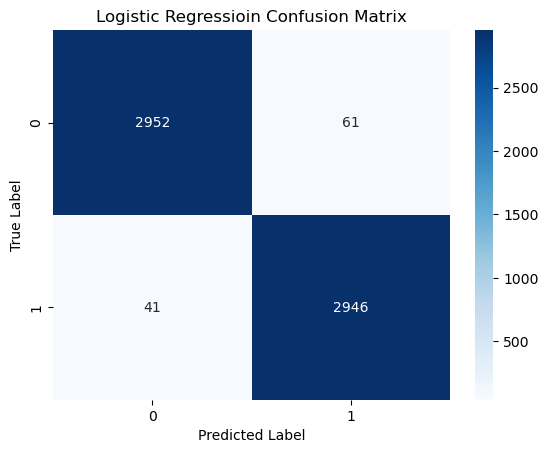

In [44]:
# Predict the labels for the test set
y_pred_lgr = lgr_grid.predict(X_test_processed)

# Generate the confusion matrix
lgr_conf_matrix = confusion_matrix(y_test, y_pred_lgr)

# Output the confusion matrix
print("Confusion Matrix:")
print(lgr_conf_matrix)

# Visualize the lgr confusion matrix
sns.heatmap(lgr_conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Logistic Regressioin Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

####


#### Decision Tree Model

In [45]:
# Setup DecisionTreeClassifier pipeline

tree_pipe = Pipeline([('vect', CountVectorizer()),
                       ('tree', DecisionTreeClassifier())])

# Define the parameters grid
tree_params = { 'vect__max_features': [1000, 2000, 5000],
          'tree__max_depth': [None, 10, 20, 50],
    'tree__min_samples_split': [2, 10, 20],
    'tree__min_samples_leaf': [1, 5, 10],
    }

# Configure GridSearchCV
tree_grid = GridSearchCV(tree_pipe, param_grid=tree_params)
tree_grid.fit(X_train_processed, y_train)

# Output the best parameters, time and scores
tree_best_params = tree_grid.best_params_
tree_acc = tree_grid.score(X_test_processed, y_test)
tree_recall = recall_score(y_test, lgr_grid.predict(X_test_processed))
tree_precision = precision_score(y_test, tree_grid.predict(X_test_processed))
tree_f1 = f1_score(y_test, tree_grid.predict(X_test_processed))

tree_index = tree_grid.best_index_
tree_time = tree_grid.cv_results_['mean_fit_time'][tree_index]


# Output the best parameters and score
print("Best parameters:", tree_best_params)
print("Accuracy:", tree_acc)
print("Precision Score:", tree_precision)
print("Recall Score:", tree_recall)
print("F1 Score:", tree_f1)
print("Time to fit:", tree_time)

Best parameters: {'tree__max_depth': 50, 'tree__min_samples_leaf': 1, 'tree__min_samples_split': 2, 'vect__max_features': 5000}
Accuracy: 0.8941666666666667
Precision Score: 0.893574297188755
Recall Score: 0.9862738533645798
F1 Score: 0.8937238493723849
Time to fit: 2.1329922676086426


Confusion Matrix:
[[2695  318]
 [ 317 2670]]


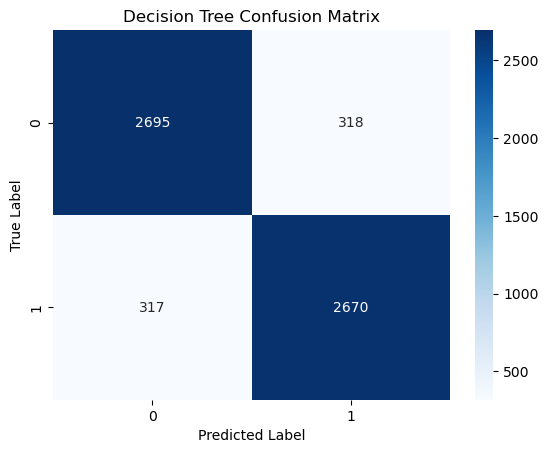

In [46]:
# Predict the labels for the test set
y_pred_tree = tree_grid.predict(X_test_processed)

# Generate the confusion matrix
tree_conf_matrix = confusion_matrix(y_test, y_pred_tree)

# Output the confusion matrix
print("Confusion Matrix:")
print(tree_conf_matrix)

# Visualize the lgr confusion matrix
sns.heatmap(tree_conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Decision Tree Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

####


#### Naive Bayes Model

In [33]:
# Setup MultinomialNB pipeline

bayes_pipe = Pipeline([('vect', CountVectorizer()),
                       ('bayes', MultinomialNB())])

# Define the parameters grid
bayes_params = { 'vect__max_features': [1000, 2000, 5000],
          'bayes__alpha': [0.01, 0.1, 1.0, 10.0]
    }

# Configure GridSearchCV
bayes_grid = GridSearchCV(bayes_pipe, param_grid=bayes_params)
bayes_grid.fit(X_train_processed, y_train)

# Output the best parameters, time and scores
bayes_best_params = bayes_grid.best_params_
bayes_acc = bayes_grid.score(X_test_processed, y_test)
bayes_recall = recall_score(y_test, bayes_grid.predict(X_test_processed))
bayes_precision = precision_score(y_test, bayes_grid.predict(X_test_processed))
bayes_f1 = f1_score(y_test, tree_grid.predict(X_test_processed))

bayes_index = bayes_grid.best_index_
bayes_time = bayes_grid.cv_results_['mean_fit_time'][bayes_index]


# Output the best parameters and score
print("Best parameters:", bayes_best_params)
print("Accuracy:", bayes_acc)
print("Precision Score:", bayes_precision)
print("Recall Score:", bayes_recall)
print("F1 Score:", bayes_f1)
print("Time to fit:", bayes_time)


Best parameters: {'bayes__alpha': 0.01, 'vect__max_features': 5000}
Accuracy: 0.942
Time to fit: 0.7605671882629395
Precision Score: 0.979295314202688
Recall Score: 0.9025778372949448
F1 Score: 0.8960777740529668


Confusion Matrix:
[[2956   57]
 [ 291 2696]]


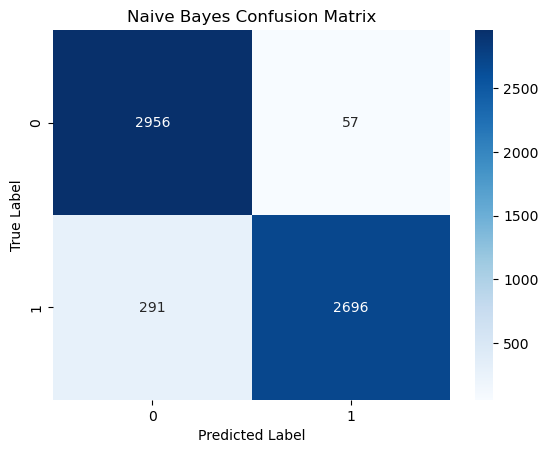

In [42]:
# Predict the labels for the test set
y_pred_bayes = bayes_grid.predict(X_test_processed)

# Generate the confusion matrix
bayes_conf_matrix = confusion_matrix(y_test, y_pred_bayes)

# Output the confusion matrix
print("Confusion Matrix:")
print(bayes_conf_matrix)

# Visualize the lgr confusion matrix
sns.heatmap(bayes_conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Naive Bayes Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

####


#### KNN Model

In [40]:
# Setup KNN pipeline

knn_pipe = Pipeline([
    ('vect', CountVectorizer()),
    ('knn', KNeighborsClassifier())
])

# Define the parameters grid
knn_params = {
    'vect__max_features': [1000, 2000, 5000],
    'knn__n_neighbors': [3, 5, 9],
    'knn__weights': ['uniform', 'distance']
}

# Configure GridSearchCV
knn_grid = GridSearchCV(knn_pipe, param_grid=knn_params)
knn_grid.fit(X_train_processed, y_train)

# Output the best parameters, time and score
knn_best_params = knn_grid.best_params_
knn_acc = knn_grid.score(X_test_processed, y_test)
knn_recall = recall_score(y_test, knn_grid.predict(X_test_processed))
knn_precision = precision_score(y_test, knn_grid.predict(X_test_processed))
knn_f1 = f1_score(y_test, knn_grid.predict(X_test_processed))

knn_index = knn_grid.best_index_
knn_time = knn_grid.cv_results_['mean_fit_time'][knn_index]

print("Best parameters:", knn_best_params)
print("Accuracy:", knn_acc)
print("Precision Score:", knn_precision)
print("Recall Score:", knn_recall)
print("F1 Score:", knn_f1)
print("Time to fit:", knn_time)

Best parameters: {'knn__n_neighbors': 3, 'knn__weights': 'distance', 'vect__max_features': 1000}
Accuracy: 0.9345
Precision Score: 0.8985863552550707
Recall Score: 0.978908603950452
F1 Score: 0.9370293222240027
Time to fit: 0.7666319847106934


Confusion Matrix:
[[2683  330]
 [  63 2924]]


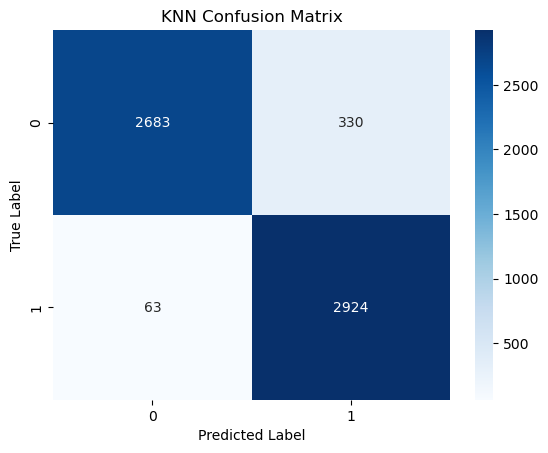

In [41]:
# Predict the labels for the test set
y_pred_knn = knn_grid.predict(X_test_processed)

# Generate the confusion matrix
knn_conf_matrix = confusion_matrix(y_test, y_pred_knn)

# Output the confusion matrix
print("Confusion Matrix:")
print(knn_conf_matrix)

# Visualize the lgr confusion matrix
sns.heatmap(knn_conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("KNN Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

####


#### SVC Model

In [51]:
# Setup SVC pipeline

svc_pipe = Pipeline([
    ('vect', CountVectorizer()),
    ('svc', SVC())
])

# Define the parameters grid
svc_params = {
    'vect__max_features': [1000, 2000, 5000],
    'svc__C': [0.1, 1, 10],
    'svc__kernel': ['linear', 'rbf']
}

# Configure GridSearchCV
svc_grid = GridSearchCV(svc_pipe, param_grid=svc_params)
svc_grid.fit(X_train_processed, y_train)

# Output the best parameters, time and scores
svc_best_params = svc_grid.best_params_
svc_acc = svc_grid.score(X_test_processed, y_test)
svc_recall = recall_score(y_test, svc_grid.predict(X_test_processed))
svc_precision = precision_score(y_test, svc_grid.predict(X_test_processed))
svc_f1 = f1_score(y_test, svc_grid.predict(X_test_processed))

svc_index = svc_grid.best_index_
svc_time = svc_grid.cv_results_['mean_fit_time'][svc_index]

print("Best parameters:", svc_best_params)
print("Accuracy:", svc_acc)
print("Precision Score:", svc_precision)
print("Recall Score:", svc_recall)
print("F1 Score:", svc_f1)
print("Time to fit:", svc_time)

Best parameters: {'svc__C': 10, 'svc__kernel': 'rbf', 'vect__max_features': 5000}
Accuracy: 0.9861666666666666
Precision Score: 0.9902093180283592
Recall Score: 0.9819216605289588
F1 Score: 0.9860480753067742
Time to fit: 315.9330442905426


Confusion Matrix:
[[2984   29]
 [  54 2933]]


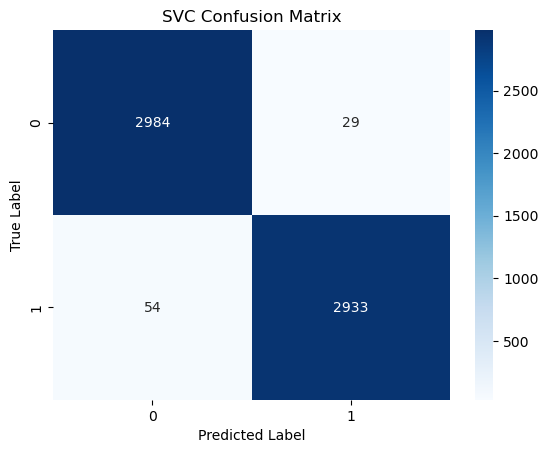

In [61]:
# Predict the labels for the test set
y_pred_svc = svc_grid.predict(X_test_processed)

# Generate the confusion matrix
svc_conf_matrix = confusion_matrix(y_test, y_pred_svc)

# Output the confusion matrix
print("Confusion Matrix:")
print(svc_conf_matrix)

# Visualize the lgr confusion matrix
sns.heatmap(svc_conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("SVC Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

####


#### Summary of the Models

In [60]:
# Summary Table

summary_df = pd.DataFrame({
              'Model': ['Logistic Regression', 'Decision Tree', 'Naive Bayes', 'KNN','SVC'], 
              'time to fit' : [lgr_time, tree_time, bayes_time, knn_time, svc_time],
              'accuracy': [lgr_acc, tree_acc, bayes_acc, knn_acc, svc_acc],
              'recall' : [lgr_recall, tree_recall, bayes_recall, knn_recall, svc_recall],
              'precision' : [lgr_precision, tree_precision, bayes_precision, knn_precision, svc_precision],
              'f1' : [lgr_f1, tree_f1, bayes_f1, knn_f1, svc_f1],
              'best_params': [lgr_best_params, tree_best_params, bayes_best_params, knn_best_params, svc_best_params],}).set_index('Model')
summary_df

,time to fit,accuracy,recall,precision,f1,best_params
Model,,,,,,
Logistic Regression,1.089988,0.983000,0.986274,0.979714,0.982983,"{'lgr__C': 0.1, 'vect__max_features': 5000}"
Decision Tree,2.132992,0.894167,0.986274,0.893574,0.893724,"{'tree__max_depth': 50, 'tree__min_samples_lea..."
Naive Bayes,0.760567,0.942000,0.902578,0.979295,0.896078,"{'bayes__alpha': 0.01, 'vect__max_features': 5..."
KNN,0.766632,0.934500,0.978909,0.898586,0.937029,"{'knn__n_neighbors': 3, 'knn__weights': 'dista..."
SVC,315.933044,0.986167,0.981922,0.990209,0.986048,"{'svc__C': 10, 'svc__kernel': 'rbf', 'vect__ma..."
